In [4]:
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [6]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /home/gom/Workspace/tf2/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-01-24 22:20:06--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4005:811::201b, 2404:6800:4005:80e::201b, 2404:6800:4005:810::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4005:811::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/home/gom/Workspace/tf2/tmp//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/home/gom/Workspace 100%[===================>]  83,84M  25,8MB/s    in 4,2s    

2024-01-24 22:20:11 (20,2 MB/s) - ‘/home/gom/Workspace/tf2/tmp//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [9]:
# Set the weights file you downloaded into a variable
local_weights_file = '/home/gom/Workspace/tf2/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

#Initialize the base model
# Set the input shape and remove the dense layers
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

# Load the pre-trained weights you downloaded
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

In [10]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [11]:
# Choose 'mixed7' as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [12]:
# Add dense layers for your classifier
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer 1 dimension
x = layers.Flatten()(last_output)
# Add fully connected layer with 1024 hideen units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)
# Append the dense network to the base model
model = Model(pre_trained_model.input,x)

# Print the model summary. See your dense network connected at the end
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                              

In [13]:
# Set the training parameters
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [15]:
# Prepare the dataset
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2024-01-24 22:58:36--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4005:810::201b, 2404:6800:4005:811::201b, 2404:6800:4005:80f::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4005:810::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65,43M  4,16MB/s    in 47s     

2024-01-24 22:59:24 (1,39 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [19]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("dataset/")
zip_ref.close()

# Define our example directories and files
base_dir=('dataset/cats_and_dogs_filtered')

# Directory with training cat pictures
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir,'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir,'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [20]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Note the validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150,150))

# Flow validation images in batches of 20 using validation datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150,150))
                                                    

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
# Train the model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_steps=50,
                    verbose=2)

Epoch 1/20
100/100 - 10s - loss: 0.3058 - accuracy: 0.8715 - val_loss: 0.1544 - val_accuracy: 0.9420 - 10s/epoch - 97ms/step
Epoch 2/20
100/100 - 6s - loss: 0.2313 - accuracy: 0.9130 - val_loss: 0.0956 - val_accuracy: 0.9680 - 6s/epoch - 56ms/step
Epoch 3/20
100/100 - 5s - loss: 0.2100 - accuracy: 0.9190 - val_loss: 0.1083 - val_accuracy: 0.9570 - 5s/epoch - 54ms/step
Epoch 4/20
100/100 - 5s - loss: 0.1981 - accuracy: 0.9345 - val_loss: 0.1078 - val_accuracy: 0.9610 - 5s/epoch - 55ms/step
Epoch 5/20
100/100 - 6s - loss: 0.1665 - accuracy: 0.9405 - val_loss: 0.1384 - val_accuracy: 0.9620 - 6s/epoch - 58ms/step
Epoch 6/20
100/100 - 6s - loss: 0.1950 - accuracy: 0.9320 - val_loss: 0.1042 - val_accuracy: 0.9660 - 6s/epoch - 57ms/step
Epoch 7/20
100/100 - 6s - loss: 0.1700 - accuracy: 0.9420 - val_loss: 0.1640 - val_accuracy: 0.9510 - 6s/epoch - 56ms/step
Epoch 8/20
100/100 - 6s - loss: 0.1652 - accuracy: 0.9485 - val_loss: 0.1145 - val_accuracy: 0.9620 - 6s/epoch - 57ms/step
Epoch 9/20
100

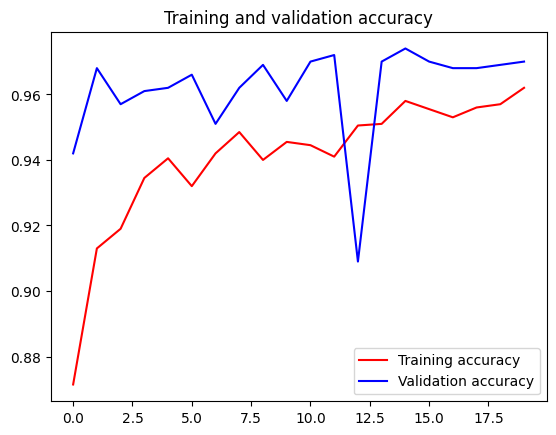

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()